In [1]:
from brian2 import *
from util.visualization_functions import *
from util.analysis_functions import *
import brian2.numpy_ as np
from random import sample
# from networkx import nx
# %matplotlib inline


In [2]:
# set_device('cpp_standalone', clean=True) # for C++ speedup
# prefs.devices.cpp_standalone.openmp_threads = 4 # number of threads; needs openmp

In [3]:
# recreate the simulation used in Ocker 2015

start_scope()

# model parameters
gL = .1 * msiemens * cm**-2 # leak conductance
vL = -72 * mV               # leak reversal potential
C = 1 * ufarad * cm**-2     # membrane capacitance
delta = 1.4 * mV            # action potential steepness
vT = -48 * mV               # action potential initiation threshold
mu = 1 * uamp * cm**-2      # noise mean
sigma = 9 * mV              # noise std dev
tau_s = 5 * ms              # synaptic time constant

# other cell params
vTh = 30 * mV               # spike threshold
vR = -72 * mV               # reset potential
tRef = 2 * ms               # action potential width (refractory time)

# network params
p = 0.15                    # connection density
N_network = 1000                     # number of neurons

# simulation params
sim_time_ms = 1000 * 60 * 100                # simulation time in ms
monitor_dt_ms = sim_time_ms / 100   # timestep for monitor evaluation

######################
#                    #
#   init the model   #
#                    #
######################
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta) + (mu + gL * sigma * sqrt(2 * C / gL) * xi) + j_e) / C : volt (unless refractory)
dj_e/dt = -j_e/tau_s : amp * meter ** -2
'''

G = NeuronGroup(N_network, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

synapses = Synapses(G, G,
                    '''w : amp * meter**-2
                        dApre/dt = -Apre / tauPre : amp * meter**-2 (event-driven)
                        dApost/dt = -Apost / tauPost : amp * meter**-2 (event-driven)''',
                    on_pre='''j_e += w
                        Apre += dApre
                        w = clip(w + Apost, 0, wMax)''',
                    on_post='''Apost += dApost
                        w = clip(w + Apre, 0, wMax)''')
           
# connect synapses
synapses.connect(condition='i!=j', p=p)
# erg = nx.erdos_renyi_graph(N_network, p, directed=True)#use erdos renyi random graph to determine synapse connections
num_synapses = len(synapses)
# for i in range(0, erg.number_of_nodes()):
#     nbs = [n for n in erg.neighbors(i)]
#     synapses.connect(i=[i], j=nbs) #connect neuron i to appropriate neighbors indicated in the erdos renyi graph
#     num_synapses += len(nbs)
#for i in range(N_network):
#    for j in range(N_network):
#        if i != j:
#            if np.random.rand() < p:
#                synapses.connect(i=i, j=j)
#                num_synapses += 1

# get connection density (for use in STDP params)
p0 = p #compute_p0(G, synapses)
# print(p0)

######################
#                    #
#    stdp params     #
#                    #
######################
# (replicated from matlab code)
#wMax = 5 * uamp * cm**-2               # max syn weight
#tauPre = 15 * ms                       # synaptic time constant
#tauPost = 2 * tauPre                   # synaptic time constant
#dApost = -wMax / 5 / N_network         # f neg (f post)
#dApre = -dApost * tauPost / tauPre     # f pos (f pre)

# (replicated from paper)
wMax = 5 * uamp * cm**-2               # max syn weight
tauPre = 5 * ms                        # synaptic time constant
tauPost = 5 * ms                       # synaptic time constant
dApre = .01
dApost = -dApre * tauPre / tauPost * 1.05
dApost *= wMax / (N_network * p0)
dApre *= wMax / (N_network * p0)

# assign synaptic weights
w0 = wMax / N_network / p0 / 10
synapses.w = w0

# monitors
sp_mon_exc = SpikeMonitor(G)
w_mon = StateMonitor(synapses, 'w', record=range(num_synapses), dt=monitor_dt_ms * ms)

# collect rate data of a subset of neurons:
#monitored_subset_size=100
#monitored_subset_size = min(monitored_subset_size, (N_network))
#idx_monitored_neurons = sample(range(N_network), monitored_subset_size)
#rate_monitor = PopulationRateMonitor(G)

# initial voltage values
for i in range(0, N_network):
    G[i].v = (np.random.normal(0, 1)*(vTh-vR)) #initial membrane potential for each neuron in neuron group

######################
#                    #
#   run simulation   #
#                    #
######################
run(sim_time_ms * ms, report='text')

Starting simulation at t=0. s for a duration of 6. ks
7.2678 (0%) simulated in 10s, estimated 2h 17m 26s remaining.
14.567 (0%) simulated in 20s, estimated 2h 16m 58s remaining.
21.9628 (0%) simulated in 30s, estimated 2h 16m 6s remaining.
30.2181 (0%) simulated in 40s, estimated 2h 11m 42s remaining.
38.3861 (0%) simulated in 50s, estimated 2h 9m 25s remaining.
46.6351 (0%) simulated in 1m 0s, estimated 2h 7m 40s remaining.
54.7841 (0%) simulated in 1m 10s, estimated 2h 6m 37s remaining.
62.8521 (1%) simulated in 1m 20s, estimated 2h 5m 57s remaining.
70.93650000000001 (1%) simulated in 1m 30s, estimated 2h 5m 23s remaining.
79.05210000000001 (1%) simulated in 1m 40s, estimated 2h 4m 50s remaining.
87.16590000000001 (1%) simulated in 1m 50s, estimated 2h 4m 22s remaining.
95.35810000000002 (1%) simulated in 2m 0s, estimated 2h 3m 51s remaining.
103.4354 (1%) simulated in 2m 10s, estimated 2h 3m 31s remaining.
111.5381 (1%) simulated in 2m 20s, estimated 2h 3m 11s remaining.
119.588000

937.9528 (15%) simulated in 19m 20s, estimated 1h 44m 20s remaining.
946.0635000000001 (15%) simulated in 19m 30s, estimated 1h 44m 10s remaining.
954.1876 (15%) simulated in 19m 40s, estimated 1h 44m 0s remaining.
962.2091 (16%) simulated in 19m 50s, estimated 1h 43m 51s remaining.
970.3461000000001 (16%) simulated in 20m 0s, estimated 1h 43m 40s remaining.
978.3841 (16%) simulated in 20m 10s, estimated 1h 43m 30s remaining.
986.5501 (16%) simulated in 20m 20s, estimated 1h 43m 20s remaining.
994.7179000000001 (16%) simulated in 20m 30s, estimated 1h 43m 9s remaining.
1002.7901 (16%) simulated in 20m 40s, estimated 1h 42m 59s remaining.
1010.8968000000001 (16%) simulated in 20m 50s, estimated 1h 42m 49s remaining.
1019.0661 (16%) simulated in 21m 0s, estimated 1h 42m 39s remaining.
1027.2276 (17%) simulated in 21m 10s, estimated 1h 42m 28s remaining.
1035.3003 (17%) simulated in 21m 20s, estimated 1h 42m 18s remaining.
1043.3249 (17%) simulated in 21m 30s, estimated 1h 42m 9s remainin

1845.2938000000001 (30%) simulated in 38m 0s, estimated 1h 25m 34s remaining.
1853.3536000000001 (30%) simulated in 38m 10s, estimated 1h 25m 24s remaining.
1861.5801000000004 (31%) simulated in 38m 20s, estimated 1h 25m 13s remaining.
1869.6620999999998 (31%) simulated in 38m 30s, estimated 1h 25m 3s remaining.
1877.7661000000003 (31%) simulated in 38m 40s, estimated 1h 24m 53s remaining.
1885.9055000000003 (31%) simulated in 38m 50s, estimated 1h 24m 43s remaining.
1894.0098 (31%) simulated in 39m 0s, estimated 1h 24m 33s remaining.
1902.1595 (31%) simulated in 39m 10s, estimated 1h 24m 23s remaining.
1910.4461000000001 (31%) simulated in 39m 20s, estimated 1h 24m 12s remaining.
1918.8644000000002 (31%) simulated in 39m 30s, estimated 1h 24m 1s remaining.
1927.1291000000003 (32%) simulated in 39m 40s, estimated 1h 23m 50s remaining.
1935.3160999999998 (32%) simulated in 39m 50s, estimated 1h 23m 40s remaining.
1943.5103 (32%) simulated in 40m 0s, estimated 1h 23m 29s remaining.
1951.

2772.9179 (46%) simulated in 57m 0s, estimated 1h 6m 20s remaining.
2781.0733 (46%) simulated in 57m 10s, estimated 1h 6m 10s remaining.
2789.1881000000003 (46%) simulated in 57m 20s, estimated 1h 6m 0s remaining.
2797.3097000000002 (46%) simulated in 57m 30s, estimated 1h 5m 50s remaining.
2805.4028000000003 (46%) simulated in 57m 40s, estimated 1h 5m 40s remaining.
2813.5121 (46%) simulated in 57m 50s, estimated 1h 5m 30s remaining.
2821.6843000000003 (47%) simulated in 58m 0s, estimated 1h 5m 20s remaining.
2829.8321 (47%) simulated in 58m 10s, estimated 1h 5m 10s remaining.
2837.9641 (47%) simulated in 58m 20s, estimated 1h 5m 0s remaining.
2846.0699 (47%) simulated in 58m 30s, estimated 1h 4m 50s remaining.
2854.2295 (47%) simulated in 58m 40s, estimated 1h 4m 40s remaining.
2862.3901 (47%) simulated in 58m 50s, estimated 1h 4m 29s remaining.
2870.5881 (47%) simulated in 59m 0s, estimated 1h 4m 19s remaining.
2878.7501 (47%) simulated in 59m 10s, estimated 1h 4m 9s remaining.
2886

3690.2041 (61%) simulated in 1h 15m 50s, estimated 47m 28s remaining.
3698.1993 (61%) simulated in 1h 16m 0s, estimated 47m 18s remaining.
3706.1381000000006 (61%) simulated in 1h 16m 10s, estimated 47m 9s remaining.
3714.3118000000004 (61%) simulated in 1h 16m 20s, estimated 46m 58s remaining.
3722.4126000000006 (62%) simulated in 1h 16m 30s, estimated 46m 48s remaining.
3730.4406 (62%) simulated in 1h 16m 40s, estimated 46m 39s remaining.
3738.4962 (62%) simulated in 1h 16m 50s, estimated 46m 29s remaining.
3746.5093000000006 (62%) simulated in 1h 17m 0s, estimated 46m 19s remaining.
3754.5821 (62%) simulated in 1h 17m 10s, estimated 46m 9s remaining.
3762.7027999999996 (62%) simulated in 1h 17m 20s, estimated 45m 59s remaining.
3770.816 (62%) simulated in 1h 17m 30s, estimated 45m 49s remaining.
3779.0006000000003 (62%) simulated in 1h 17m 40s, estimated 45m 39s remaining.
3787.1755000000003 (63%) simulated in 1h 17m 50s, estimated 45m 29s remaining.
3795.3227 (63%) simulated in 1h 

4613.1081 (76%) simulated in 1h 34m 40s, estimated 28m 28s remaining.
4621.3966 (77%) simulated in 1h 34m 50s, estimated 28m 17s remaining.
4629.5645 (77%) simulated in 1h 35m 0s, estimated 28m 7s remaining.
4637.9218 (77%) simulated in 1h 35m 10s, estimated 27m 57s remaining.
4646.2384 (77%) simulated in 1h 35m 20s, estimated 27m 47s remaining.
4654.6021 (77%) simulated in 1h 35m 30s, estimated 27m 36s remaining.
4662.9166000000005 (77%) simulated in 1h 35m 40s, estimated 27m 26s remaining.
4671.149600000001 (77%) simulated in 1h 35m 50s, estimated 27m 16s remaining.
4679.4415 (77%) simulated in 1h 36m 0s, estimated 27m 6s remaining.
4687.7861 (78%) simulated in 1h 36m 10s, estimated 26m 55s remaining.
4696.1565 (78%) simulated in 1h 36m 20s, estimated 26m 45s remaining.
4704.5121 (78%) simulated in 1h 36m 30s, estimated 26m 34s remaining.
4712.926100000001 (78%) simulated in 1h 36m 40s, estimated 26m 24s remaining.
4721.2561000000005 (78%) simulated in 1h 36m 50s, estimated 26m 14s r

5564.1801000000005 (92%) simulated in 1h 53m 50s, estimated 8m 55s remaining.
5572.328100000001 (92%) simulated in 1h 54m 0s, estimated 8m 45s remaining.
5580.4161 (93%) simulated in 1h 54m 10s, estimated 8m 35s remaining.
5588.572700000001 (93%) simulated in 1h 54m 20s, estimated 8m 25s remaining.
5596.5921 (93%) simulated in 1h 54m 30s, estimated 8m 15s remaining.
5604.6476 (93%) simulated in 1h 54m 40s, estimated 8m 5s remaining.
5612.6765000000005 (93%) simulated in 1h 54m 50s, estimated 7m 55s remaining.
5620.747600000001 (93%) simulated in 1h 55m 0s, estimated 7m 46s remaining.
5628.8099 (93%) simulated in 1h 55m 10s, estimated 7m 36s remaining.
5636.7861 (93%) simulated in 1h 55m 20s, estimated 7m 26s remaining.
5644.7861 (94%) simulated in 1h 55m 30s, estimated 7m 16s remaining.
5652.7901 (94%) simulated in 1h 55m 40s, estimated 7m 6s remaining.
5660.8541000000005 (94%) simulated in 1h 55m 50s, estimated 6m 56s remaining.
5668.8855 (94%) simulated in 1h 56m 0s, estimated 6m 47s

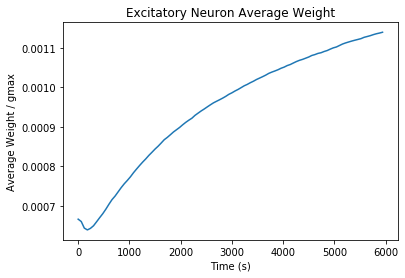

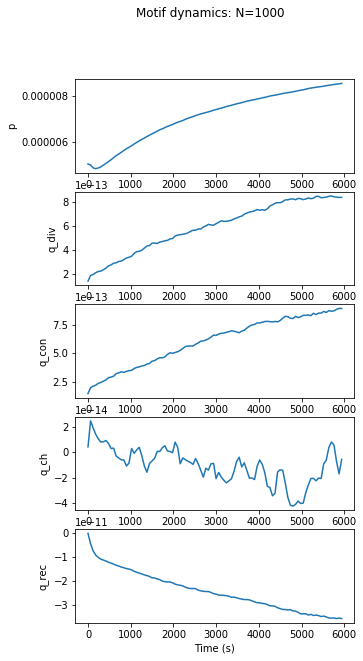

In [4]:
# more plots
plot_avg_syn_weight(w_mon, wMax)

# figure 7
plot_motif_dynamics(w_mon, synapses, N_network, use_p0=False, save_fig=False)

In [ ]:
#plot_network_activity(rate_monitor, sp_mon_exc, w_mon, idx_monitored_neurons, t_min=400*1000*ms, t_max=700*1000*ms)